# Does the macroeconomy exhibit recurring patterns? —— A MacroScope Model to quantify the business cycle

**Team Member**
| Name | Student Number |
| :----: | :--------------: |
| Ruiyang Ge | 2301212326 |
| Yuhang Qin | 2301212373 |
| Yuyang Zhang | 2301212424 |
| Yichao Chen | 2301212314 |
| Guanzhou Jiang | 2301212234 |

Last week, we completed the writing of the backtesting framework, which allows us to backtest strategies with known positions. The next step is to collect data according to the previous framework to compare the similarity of macroeconomic variables between each pair of months. We have selected the following dimensions for this purpose:

| Dimension | Input variable |
| :----: | :--------------: |
| Liquidity | Social Financing |
| Inflation | CPI |
| Economic Prosperity | PMI |
| Overseas Liquidity | 10Y Rate-Tips |
| Monetary Conditions | R007/DR007/The Central Bank's Liquidity Injection |

Among these datasets, some possess high-frequency data, such as the 10-Year Rate-TIPS, R007/DR007, and the Central Bank's Liquidity Injection, which are available on a daily or weekly basis. However, the remainder of the data is predominantly monthly. Since we intend to employ the Dynamic Time Warping (DTW) algorithm to calculate the similarity between each pair of months, it is imperative that we utilize high-frequency data. One approach is to identify high-frequency proxy variables for the low-frequency data and directly use these proxies for analysis. This method is relatively straightforward, and we will retain this approach as a viable option. Another method involves using high-frequency data to fit the variables we require, thereby obtaining high-frequency fitted data. This week, we have performed fitting for several variables, including PMI, Social Financing, and CPI (the data for Social Financing and CPI are still being processed but are largely complete, hence not yet uploaded; only the methodology for PMI is shared here). **If there is room for improvement in our methodology, we welcome your constructive criticism and suggestions.**

Initially, we consulted academic papers and research reports (Guotai Junan, 2021) and discovered that the PMI (Purchasing Managers' Index) formula is as follows: 


Manufacturing PMI = New Orders Index × 30% + Production Index × 25% + Employment Index × 20% + (100 - Suppliers' Delivery Times Index) × 15% + Main Raw Materials Inventory Index × 10%


 Consequently, a significant portion of the PMI is related to industrial production and demand. Therefore, we selected the following indicators from the Wind database: `Operating Rate: Rebar - Major Steel Mills`, 

 `Operating Rate: Automotive Tires (Semi-Steel)`, 

 `Load Rate: Polyester Staple Fiber`, 

 `Industrial Chain Load Rate: Purified Terephthalic Acid - Jiangsu and Zhejiang Looms`,

`Transaction Area: Commercial Housing in 30 Large and Medium-Sized Cities`, 

`Transaction Land Area in 100 Large and Medium-Sized Cities`, 

`Futures Settlement Price (Active Contract): Coking Coal`, 

`Shanghai Price: Rebar (HRB400E, 20mm)`.


# Data preparation

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df_weekly = pd.read_excel(r'C:\QPS\PMI.xlsx',skiprows=1,sheet_name='Sheet3')
df_weekly['日期'] = pd.to_datetime(df_weekly['指标名称'], errors='coerce')
# Set the '日期' column as the index
df_weekly.set_index('日期', inplace=True)
df_weekly = df_weekly.drop(columns=['指标名称'])
df_weekly = df_weekly.fillna(method='ffill')
df_weekly = df_weekly.resample('W').mean() # resample to weekly data

In [2]:
df_weekly

,中国:开工率:螺纹钢:主要钢厂:周:结束日7,中国:开工率:汽车轮胎(半钢胎):周:结束日7,中国:装置负荷率:涤纶短纤:周:结束日7,中国:产业链负荷率:精对苯二甲酸:江浙织机:周:平均值:结束日7,中国:30大中城市:成交面积:商品房:周:平均值:结束日7,中国:100大中城市:成交土地占地面积:当周值,期货结算价(活跃合约):焦煤:周:平均值:结束日7,"上海:价格:螺纹钢(HRB400E,20mm):周:平均值:结束日7"
日期,,,,,,,,
2015-03-01,64.60,41.23,49.00,10.000000,21.714363,730.5604,728.333333,2345.0
2015-03-08,67.00,59.59,51.00,20.000000,38.410723,1054.5874,720.600000,2336.0
2015-03-15,70.60,63.48,55.00,45.000000,52.876438,2351.5698,718.200000,2308.0
2015-03-22,74.18,67.21,55.00,65.000000,53.886760,2417.7039,711.600000,2384.0
2015-03-29,76.10,69.09,69.00,70.000000,60.144075,977.0021,701.200000,2468.0
...,...,...,...,...,...,...,...,...
2025-01-26,32.12,70.30,74.33,22.950000,25.171454,1607.4799,1143.600000,3400.0
2025-02-02,32.12,19.84,74.33,22.950000,1.954117,222.6028,1134.500000,3400.0
2025-02-09,34.12,29.38,69.86,12.093333,9.387271,1063.1971,1126.666667,3400.0


In [5]:
df_monthly = pd.read_excel(r'C:\QPS\PMI.xlsx',skiprows=1,sheet_name='Sheet3')
df_monthly['日期'] = pd.to_datetime(df_monthly['指标名称'], errors='coerce')
# Set the '日期' column as the index
df_monthly.set_index('日期', inplace=True)
df_monthly.drop(columns=['指标名称'], inplace=True)
df_monthly = df_monthly.resample('M').mean()
df_monthly = df_monthly.fillna(method='ffill') #resample to monthly data

In [6]:
df_pmi = pd.read_excel(r'C:\QPS\PMI.xlsx',skiprows=1,sheet_name='Sheet2')
df_pmi['日期'] = pd.to_datetime(df_pmi['指标名称'], errors='coerce')
# Set the '日期' column as the index
df_pmi.set_index('日期', inplace=True)
df_pmi.drop(columns=['指标名称'], inplace=True)
df_pmi = df_pmi.resample('M').last()
df_pmi = df_pmi[df_pmi.index>'2015-2-28'] #read pmi data from 2015-3-1

In [ ]:
df_pmi.head() # Industry PMI, New Orders PMI and Production PMI

,中国:制造业PMI,中国:制造业PMI:生产,中国:制造业PMI:新订单
日期,,,
2015-03-31,50.1,52.1,50.2
2015-04-30,50.1,52.6,50.2
2015-05-31,50.2,52.9,50.6
2015-06-30,50.2,52.9,50.1
2015-07-31,50.0,52.4,49.9


In [8]:
# Prepare the data for the model
df_x = df_monthly.iloc[:-1,:]
# df_x = pd.concat([df_x,df_pmi.shift(1)],axis=1)
df_x = df_x.dropna()
df_y = df_pmi.copy()
display(df_x)
display(df_y)

,中国:开工率:螺纹钢:主要钢厂:周:结束日7,中国:开工率:汽车轮胎(半钢胎):周:结束日7,中国:装置负荷率:涤纶短纤:周:结束日7,中国:产业链负荷率:精对苯二甲酸:江浙织机:周:平均值:结束日7,中国:30大中城市:成交面积:商品房:周:平均值:结束日7,中国:100大中城市:成交土地占地面积:当周值,期货结算价(活跃合约):焦煤:周:平均值:结束日7,"上海:价格:螺纹钢(HRB400E,20mm):周:平均值:结束日7"
日期,,,,,,,,
2015-03-31,70.4960,60.1200,55.800000,42.000000,45.406472,1506.284720,715.986667,2368.200000
2015-04-30,78.6850,71.0575,73.000000,78.500000,58.711548,972.195975,671.350000,2335.250000
2015-05-31,81.5860,73.6300,77.600000,78.200000,70.380982,1515.646940,676.440000,2264.900000
2015-06-30,81.3750,74.2125,75.250000,71.000000,72.155055,2023.830325,684.162500,2097.375000
2015-07-31,77.2475,70.9100,64.000000,66.925000,72.025630,2007.574200,640.300000,1925.000000
...,...,...,...,...,...,...,...,...
2024-09-30,36.6740,78.6640,70.640000,70.386133,22.910594,1672.396260,1298.173333,3298.266667
2024-10-31,42.7975,77.5825,75.513333,77.096000,29.560534,1486.924450,1440.087500,3619.000000
2024-11-30,41.7975,79.1975,75.702500,76.679375,38.200970,2138.159800,1320.325000,3502.000000


,中国:制造业PMI,中国:制造业PMI:生产,中国:制造业PMI:新订单
日期,,,
2015-03-31,50.1,52.1,50.2
2015-04-30,50.1,52.6,50.2
2015-05-31,50.2,52.9,50.6
2015-06-30,50.2,52.9,50.1
2015-07-31,50.0,52.4,49.9
...,...,...,...
2024-09-30,49.8,51.2,49.9
2024-10-31,50.1,52.0,50.0
2024-11-30,50.3,52.4,50.8


# XGBoost Model to fit PMI

mean absolute error: 0.9152839018919761


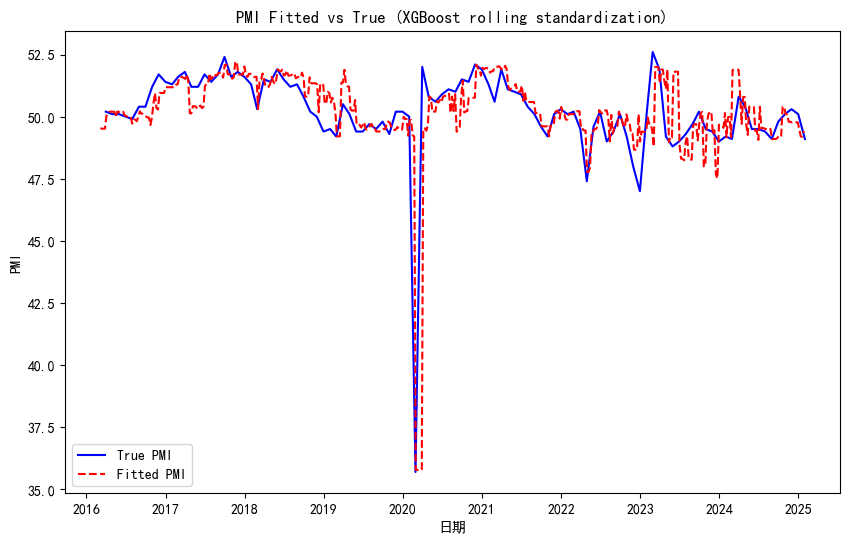

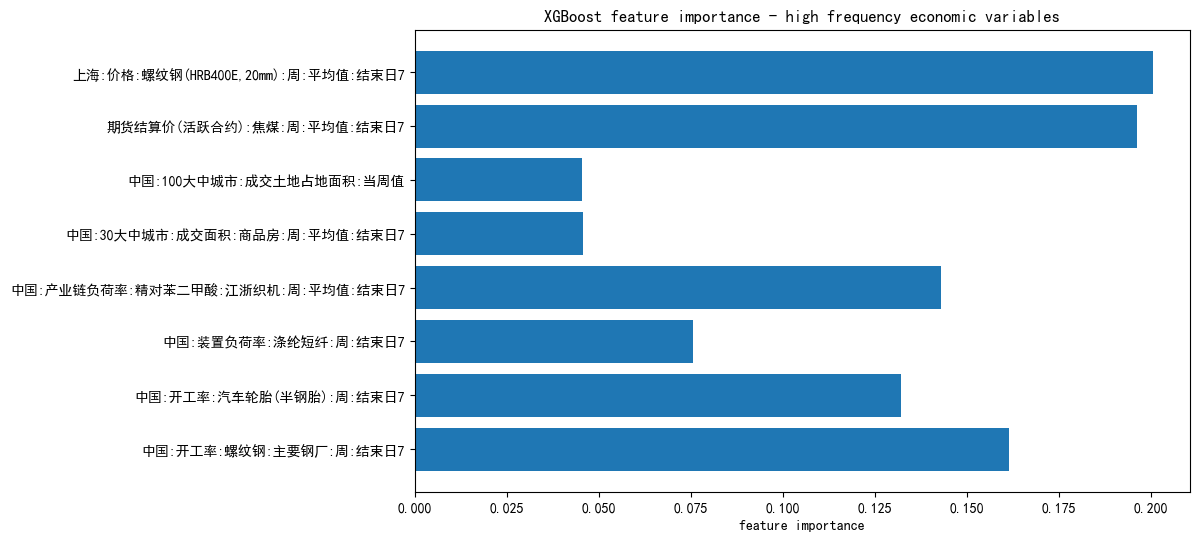

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# set the style of the plots
plt.rcParams['font.sans-serif'] = ['SimHei']

# Rolling training and prediction, rolling window size = 12
window_size = 12
predictions = []
predictions_mean=[]
true_values = []
true_values_2 = []
true_dates_2 = []
feature_importances = np.zeros(df_x.shape[1])

# store the predicted and true values
pred_dates = []
true_dates = []

# rolling window training and prediction
for i in range(window_size, len(df_y)):
    # 获取当前窗口的训练数据（过去12个月）
    X_train = df_x.iloc[i - window_size:i, :]  # high frequency economic variables Monthly data
    y_train = df_y['中国:制造业PMI'].iloc[i - window_size:i]  # Monthly PMI data
    
    # get the next month's data as the test set
    next_month = df_y.index[i] #test data
    next_month_year = next_month.year
    next_month_num = next_month.month
    next_month_start_date = pd.Timestamp(f"{next_month_year}-{next_month_num:02d}-01")
    
    # find the weekly data of the next month
    df_weekly_filtered = df_weekly[(df_weekly.index >= next_month_start_date) & (df_weekly.index <= next_month)]
    
    # standardize the training set
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # rolling standardization
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # fit the XGBoost model
    X_test = df_weekly_filtered  
    y_test = df_y['中国:制造业PMI'].iloc[i:i+1]  


    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # make sure the training set and test set are not empty
    if X_train_scaled.shape[0] > 0 and X_test_scaled.shape[0] > 0:

        model = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
        model.fit(X_train_scaled, y_train_scaled.ravel())
        
        # fit the model and make predictions
        y_pred_scaled = model.predict(X_test_scaled)
        
        # rescale the predicted and true values
        y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
        

        predictions.extend(y_pred_rescaled.flatten())
        predictions_mean.extend([np.mean(y_pred_rescaled)])
        true_values.extend([y_test_rescaled[0][0]]*len(y_pred_rescaled))  # 填充真实PMI的每周数据
        true_values_2.extend([y_test_rescaled[0][0]])


        pred_dates.extend(df_weekly_filtered.index)  # 用周度数据的日期
        true_dates.extend([next_month] * len(df_weekly_filtered))  # 用月度数据的日期填充真实数据
        true_dates_2.extend([next_month])

        # importances of the features
        feature_importances += model.feature_importances_

# calculate the mean absolute error
mae = mean_absolute_error(true_values_2, predictions_mean)
print(f"mean absolute error: {mae}")

# calculate the feature importances
feature_importances /= (len(df_y) - window_size)

# get the feature names
feature_names = df_x.columns


df_pred = pd.DataFrame({'Date': pred_dates, 'Predicted PMI': predictions})
df_pred_mean = pd.DataFrame({'Date': true_dates_2, 'Predicted PMI': predictions_mean})
df_true = pd.DataFrame({'Date': true_dates, 'True PMI': true_values})
df_true_2 = pd.DataFrame({'Date': true_dates_2, 'True PMI': true_values_2})

# p
plt.figure(figsize=(10, 6))
plt.plot(df_true['Date'], df_true['True PMI'], label='True PMI', color='blue', linestyle='-')
plt.plot(df_pred['Date'], df_pred['Predicted PMI'], label='Fitted PMI', color='red', linestyle='--')
plt.xlabel('日期')
plt.ylabel('PMI')
plt.title('PMI Fitted vs True (XGBoost rolling standardization)')
plt.legend()
plt.show()

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('feature importance')
plt.title('XGBoost feature importance - high frequency economic variables')
plt.show()

# PMI monthly DTW distance

In [10]:
df_pred

,Date,Predicted PMI
0,2016-03-06,49.532368
1,2016-03-13,49.514900
2,2016-03-20,49.514900
3,2016-03-27,49.514938
4,2016-04-03,50.034367
...,...,...
460,2024-12-29,49.769138
461,2025-01-05,49.482990
462,2025-01-12,49.199539
463,2025-01-19,49.194607


In [11]:
from fastdtw import fastdtw
import matplotlib.dates as mdates
monthly_data = df_pred.groupby(pd.Grouper(key='Date', freq='M'))

# Define the function to calculate DTW distance
def calculate_dtw(series1, series2):
    # Calculate the DTW distance if both series have more than 1 point
    if len(series1) > 1 and len(series2) > 1:
        distance, _ = fastdtw(series1, series2)
        return distance
    else:
        return None  # Return None if the series is too short

# Initialize an empty dictionary to store the results
dtw_results = {}

# Loop over each variable (column) in the DataFrame, and calculate DTW for each
for i, variable in enumerate(df_pred.columns[1:]):  # Skip the 'date' column
    dtw_distances = []
    month_labels = []
    
    # Loop through each month starting from the second month (to compare with previous months)
    for end_month, end_data in monthly_data:
        if end_month <= pd.Timestamp('2025-01-31'):  # We want to compare until January 2025
            if end_month == pd.Timestamp('2025-01-31'):  # We are interested in January 2025
                # Get the time series for January 2025
                series1 = end_data[variable].values
                
                for start_month, start_data in monthly_data:
                    if start_month < end_month:  # Only compare with previous months
                        # Get the time series for the previous months
                        series2 = start_data[variable].values
                        distance = calculate_dtw(series1, series2)
                        if distance is not None:
                            dtw_distances.append(distance)
                            month_labels.append(start_month.strftime('%Y-%m'))  # Format the month label as 'yyyy-mm'

    # Add the results to the dictionary with the variable name as the key
    dtw_results[variable] = pd.Series(dtw_distances, index=month_labels)

# Convert the dictionary to a DataFrame
dtw_df = pd.DataFrame(dtw_results)

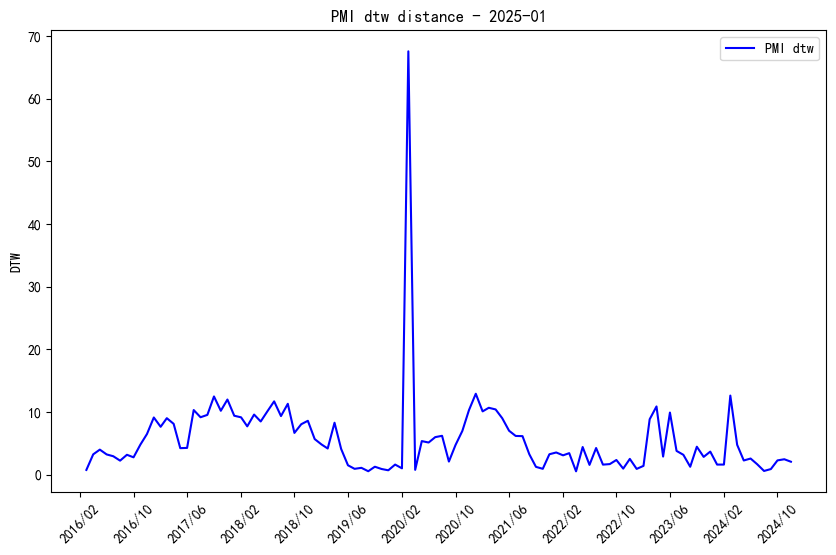

In [12]:
dtw_df.index = pd.to_datetime(dtw_df.index)

# 绘制真实值与预测值对比图
plt.figure(figsize=(10, 6))
plt.plot(dtw_df.index, dtw_df, label='PMI dtw', color='blue', linestyle='-')
plt.ylabel('DTW')
plt.title('PMI dtw distance - 2025-01')
plt.legend()
# 设置日期格式：每三个月显示一次
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))  # 每个月显示年份-月份
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=8))  # 每三个月显示一次标签
# 自动旋转日期标签以避免重叠
plt.xticks(rotation=45)
plt.show()

We can select the k months (k=10) with the closest DTW distance to January 2025 and intuitively assess the degree of similarity among these months.

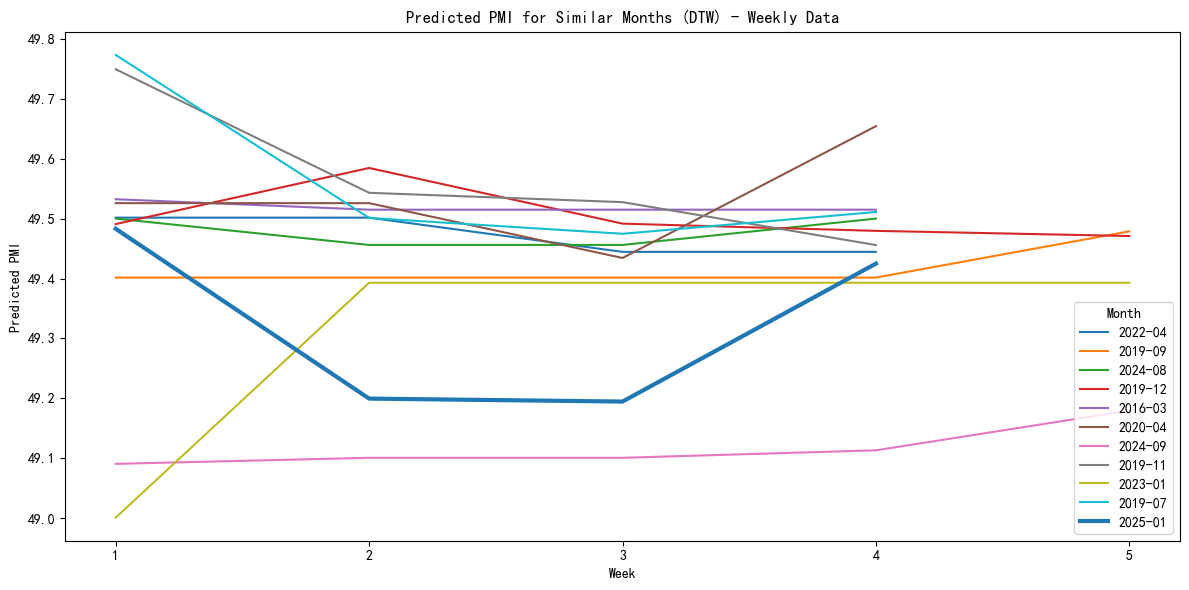

In [13]:
similar_dates = dtw_df.sort_values(by='Predicted PMI', ascending=True).head(10).index
similar_dates = similar_dates.append(pd.to_datetime(['2025-01-01']))

# 提取出年月
months = [(date.year, date.month) for date in similar_dates]

# 设置绘图
plt.figure(figsize=(12, 6))

# 遍历每个相似的年月
for year, month in months:
    # 筛选出该年月的数据
    month_data = df_pred[(df_pred['Date'].dt.year == year) & (df_pred['Date'].dt.month == month)]
    
    # 计算该月份的周次（1, 2, 3, 4, 5）
    month_data['Week'] = [i for i in range(1, len(month_data) + 1)]
    
    # 判断是否是2025年1月，并加粗
    if year == 2025 and month == 1:
        plt.plot(month_data['Week'], month_data['Predicted PMI'], label=f"{year}-{month:02d}", linewidth=3)  # 加粗线条
    else:
        plt.plot(month_data['Week'], month_data['Predicted PMI'], label=f"{year}-{month:02d}")

# 设置标题、标签和图例
plt.title('Predicted PMI for Similar Months (DTW) - Weekly Data')
plt.xlabel('Week')
plt.ylabel('Predicted PMI')
plt.legend(title="Month")
plt.xticks(range(1, 6))  # 横轴显示 1, 2, 3, 4, 5
plt.tight_layout()

# 显示图表
plt.show()

# MLP(another method)

Using the Multilayer Perceptron (MLP), we observed a reduction in the mean average error; however, the volatility of the results has increased somewhat, particularly in the month of February each year. This fluctuation may be attributed to seasonal factors, as the PMI is inherently a month-on-month data indicator.

mean average error: 0.8729385380634114


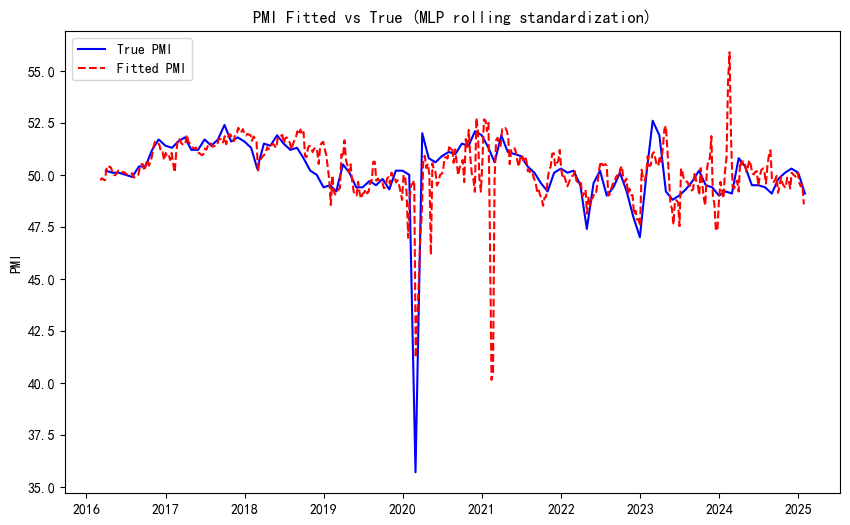

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# 字体设置微软雅黑
plt.rcParams['font.sans-serif'] = ['SimHei']

# 设置滚动训练的窗口大小（假设用过去12个月的数据进行训练）
window_size = 12
predictions = []
predictions_mean=[]
true_values = []
true_values_2 = []
true_dates_2 = []
feature_importances = np.zeros(df_x.shape[1])

# 存储真实PMI和预测PMI的日期
pred_dates = []
true_dates = []

# 滚动训练和预测
for i in range(window_size, len(df_y)):
    # 获取当前窗口的训练数据（过去12个月）
    X_train = df_x.iloc[i - window_size:i, :]  # 高频经济变量的月度数据
    y_train = df_y['中国:制造业PMI'].iloc[i - window_size:i]  # 月度PMI数据

    
    # 获取当前月的日期
    next_month = df_y.index[i] #测试集的月度数据
    next_month_year = next_month.year
    next_month_num = next_month.month
    next_month_start_date = pd.Timestamp(f"{next_month_year}-{next_month_num:02d}-01")
    
    # 筛选下一个月的周度数据
    df_weekly_filtered = df_weekly[(df_weekly.index >= next_month_start_date) & (df_weekly.index <= next_month)]
    
    # 初始化并训练标准化器
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 仅使用当前窗口数据对训练集进行标准化
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # 获取下一个月的四个周度数据作为测试集（每个周日的日期）
    X_test = df_weekly_filtered  # 使用下一个月的周度数据
    y_test = df_y['中国:制造业PMI'].iloc[i:i+1]  # 对应的月度PMI数据

    # 对测试集进行标准化（使用训练集的scaler）
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # 确保训练集和测试集不为空
    if X_train_scaled.shape[0] > 0 and X_test_scaled.shape[0] > 0:
        # 初始化并训练XGBoost模型
        model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
        model.fit(X_train_scaled, y_train_scaled.ravel())
        
        # 进行预测（预测四个周度数据）
        y_pred_scaled = model.predict(X_test_scaled)
        
        # 反标准化预测值和真实值
        y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
        
        # 记录四个预测值
        predictions.extend(y_pred_rescaled.flatten())
        predictions_mean.extend([np.mean(y_pred_rescaled)])
        true_values.extend([y_test_rescaled[0][0]]*len(y_pred_rescaled))  # 填充真实PMI的每周数据
        true_values_2.extend([y_test_rescaled[0][0]])

        # 获取当前月最后一个日期作为PMI的代表日期
        pred_dates.extend(df_weekly_filtered.index)  # 用周度数据的日期
        true_dates.extend([next_month] * len(df_weekly_filtered))  # 用月度数据的日期填充真实数据
        true_dates_2.extend([next_month])

        # # 获取并累加当前模型的特征重要性
        # feature_importances += model.feature_importances_

# 计算并输出平均绝对误差
mae = mean_absolute_error(true_values_2, predictions_mean)
print(f"mean average error: {mae}")

# 计算特征重要性的平均值
feature_importances /= (len(df_y) - window_size)

# 获取特征名称
feature_names = df_x.columns

# 将预测PMI和真实PMI的数据转换为DataFrame，以便绘制
df_pred = pd.DataFrame({'Date': pred_dates, 'Predicted PMI': predictions})
df_pred_mean = pd.DataFrame({'Date': true_dates_2, 'Predicted PMI': predictions_mean})
df_true = pd.DataFrame({'Date': true_dates, 'True PMI': true_values})
df_true_2 = pd.DataFrame({'Date': true_dates_2, 'True PMI': true_values_2})

# 绘制真实值与预测值对比图
plt.figure(figsize=(10, 6))
plt.plot(df_true['Date'], df_true['True PMI'], label='True PMI', color='blue', linestyle='-')
plt.plot(df_pred['Date'], df_pred['Predicted PMI'], label='Fitted PMI', color='red', linestyle='--')
plt.ylabel('PMI')
plt.title('PMI Fitted vs True (MLP rolling standardization)')
plt.legend()
plt.show()



Since we have employed a rolling fitting approach, utilizing the past 12 months of data as a training set to fit the weekly data of the following month, this may result in some deviation in the forecasted outcomes. However, it ensures that no future information is used, making it more suitable for investment purposes. Our team has contemplated another approach, which involves training on data from all time periods to derive the weights of each variable for fitting. This method would allow for a more comprehensive utilization of information but would inevitably involve the use of future information during backtesting. We hope the professor can provide us with some guidance, which would be beneficial for our subsequent fitting of high-frequency GDP and CPI data.

Another issue that has arisen during this project is the concern raised by a team member that our fitted data will inevitably contain errors. They suggested using direct high-frequency data for multi-dimensional DTW calculations, arguing that this would preserve more of the original information, albeit potentially introducing some noise.

Lastly, the timing of monthly portfolio adjustments based on macroeconomic data may not have a significant impact in the A-share market. Some of the research reports we have reviewed suggest that it may not necessarily yield excess returns. Nevertheless, our current work remains highly meaningful in assessing the macroeconomic landscape and other aspects. We hope that our research can better inform our investment decisions, and we are committed to striving towards this goal.
